In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

sns.set(font_scale=1.5, rc={'text.usetex' : True})

In [3]:
def coef_p(x, m):
    return -m * np.exp(-m * x)

def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [15]:
xs = np.linspace(-150, 150, 1000)   
global_cam = np.load('../global_cam.npy')
global_vec = np.mean(global_cam * 8, axis=(1,2))
print(global_vec)

[0.05724691 0.03897411 0.04114795 0.0334613  0.02592686 0.03431852
 0.06794754 0.0751227  0.06971933 0.01749773 0.04761803 0.07181241
 0.03265777 0.03866855 0.35562736 0.02293269 0.02371103 0.05002315
 0.04902108 0.02950957]


<AxesSubplot:xlabel='$z$', ylabel='$M_z$'>

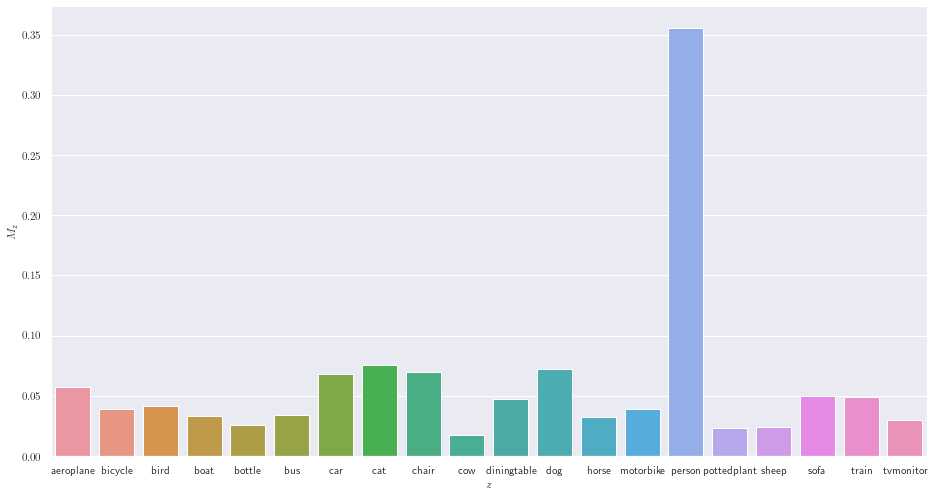

In [16]:
d = {}
d['$M_z$'] = global_vec
d['$z$'] = object_categories
df = pd.DataFrame(data=d)
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(x="$z$", y="$M_z$", data=df)

## Verify gradient computation

In [17]:
logits = torch.randn(1, 20)
labels = torch.zeros(1, 20)
labels[0][4] = 1
logits.requires_grad = True

logits_wg = logits.unsqueeze(2).unsqueeze(2) * torch.from_numpy(global_cam)
logits_wg = torch.mean(logits_wg * 24, dim=(2,3))
bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')(logits_wg, labels)

our_grad = []
for idx, m in enumerate(global_vec):
    s = logits[0][idx].detach()
    if idx == 4:
        our_grad += [coef_p(s, m) * sigmoid(m * s)/20]
    else:
        our_grad += [m * sigmoid(m * s)/20]
our_grad = torch.tensor(our_grad)
bce_loss.backward()
print(our_grad)
print(logits.grad)

tensor([ 0.0015,  0.0010,  0.0010,  0.0008, -0.0006,  0.0008,  0.0017,  0.0019,
         0.0018,  0.0004,  0.0012,  0.0018,  0.0008,  0.0009,  0.0055,  0.0006,
         0.0006,  0.0012,  0.0012,  0.0008])
tensor([[ 0.0049,  0.0029,  0.0030,  0.0024, -0.0019,  0.0025,  0.0049,  0.0058,
          0.0059,  0.0013,  0.0037,  0.0058,  0.0024,  0.0027,  0.0043,  0.0016,
          0.0018,  0.0036,  0.0037,  0.0024]])


## Visualize gradient for each class

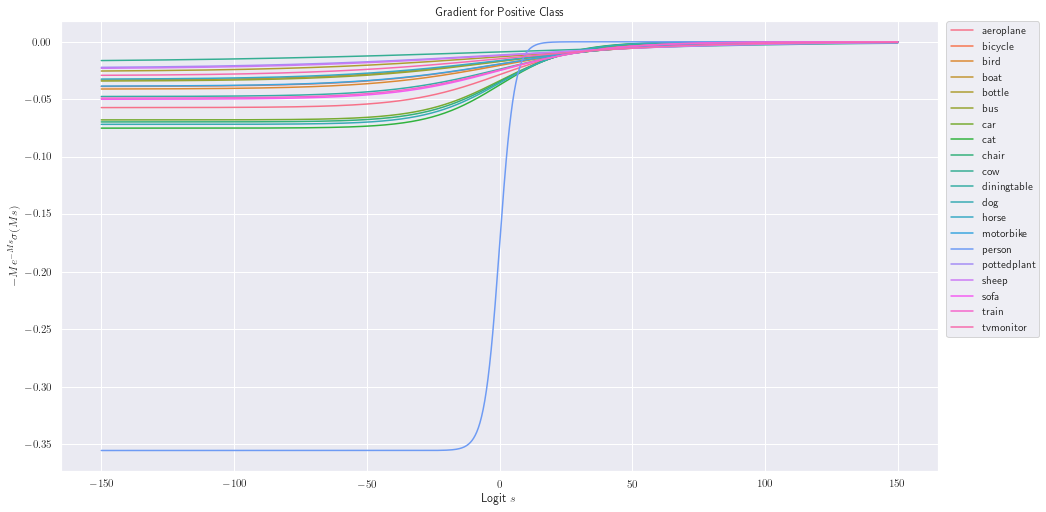

In [18]:
dp = {}
dp['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    dp[object_categories[idx]] = coef_p(xs, m) * sigmoid(m * xs)

df = pd.DataFrame(data=dp)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$-Me^{-Ms}\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$-Me^{-Ms}\sigma(Ms)$",
    hue="Class"
)

sns.set(rc={'figure.figsize':(15.7,8.27)})

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('Gradient for Positive Class')
plt.savefig('grad_pos.pdf', bbox_inches='tight', pad_inches=0)

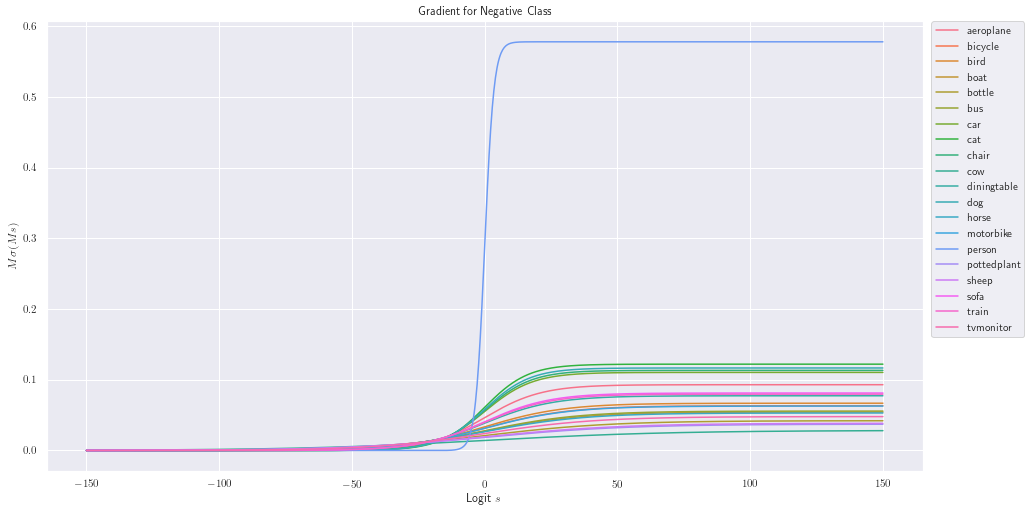

In [11]:
dn = {}
dn['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    dn[object_categories[idx]] = m * sigmoid(m * xs)

df = pd.DataFrame(data=dn)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$M\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$M\sigma(Ms)$",
    hue="Class"
)

sns.set(rc={'figure.figsize':(15.7,8.27)})

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('Gradient for Negative Class')
plt.savefig('grad_neg.pdf', bbox_inches='tight', pad_inches=0)

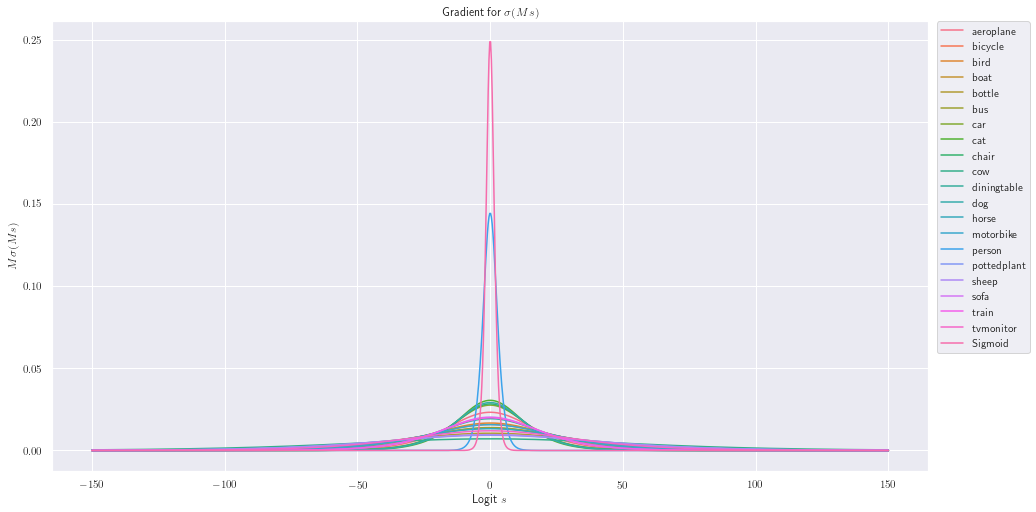

In [14]:
def grad_sigmoid(m,x):
    return (m*np.exp(-m*x))/((np.exp(-m*x)+1)*(np.exp(-m*x)+1))

dn = {}
dn['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    dn[object_categories[idx]] = grad_sigmoid(m, xs)
dn['Sigmoid'] = (np.exp(-xs))/((np.exp(-xs) + 1) * (np.exp(-xs) + 1))

df = pd.DataFrame(data=dn)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$M\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$M\sigma(Ms)$",
    hue="Class"
)

sns.set(rc={'figure.figsize':(15.7,8.27)})

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('Gradient for $\sigma(Ms)$')
plt.savefig('grad_sig.pdf', bbox_inches='tight', pad_inches=0)

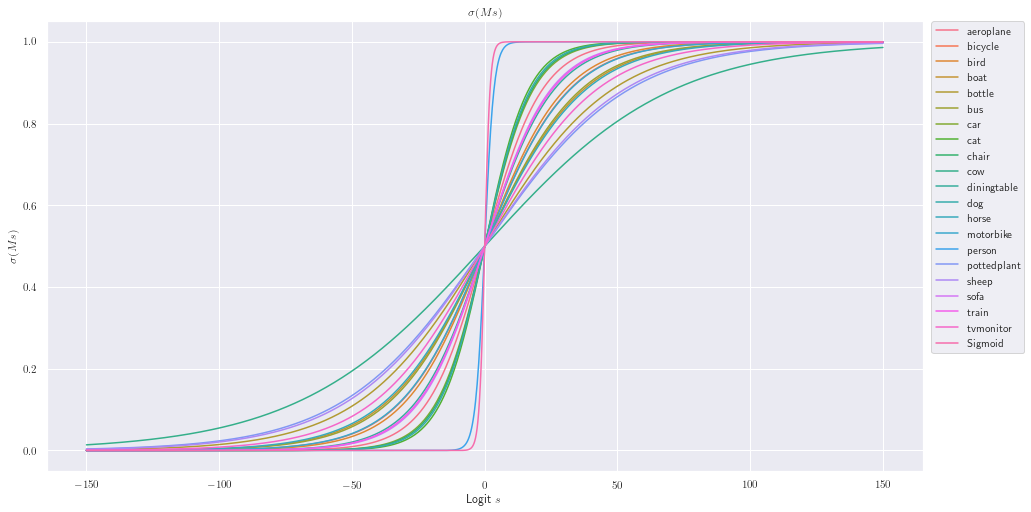

In [12]:
d = {}
d['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    d[object_categories[idx]] = sigmoid(m * xs)
d['Sigmoid'] = sigmoid(xs)

df = pd.DataFrame(data=d)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$\sigma(Ms)$",
    hue="Class"
)

sns.set(rc={'figure.figsize':(15.7,8.27)})

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('$\sigma(Ms)$')
plt.savefig('sigmoid.pdf', bbox_inches='tight', pad_inches=0)

In [27]:
# C2AM
mious = {'C$^2$AM: mIoU 69.1': np.array([0.88614127, 0.7224135 , 0.37948761, 0.79298366, 0.58668022,      
        0.65225267, 0.84204695, 0.74913452, 0.84103382, 0.39801444,              
        0.82183807, 0.53044886, 0.7776393 , 0.83748432, 0.79899954,              
        0.72188689, 0.51614735, 0.85656707, 0.62780143, 0.62370535,              
        0.53934591]), 'CAM: mIoU 65.3': np.array([0.87917766, 0.67227121, 0.35942197, 0.76256142, 0.58875524,
        0.61210626, 0.80195505, 0.69033153, 0.74489198, 0.33625327,
        0.7751565 , 0.41982922, 0.72092112, 0.7774972 , 0.75148308,
        0.68446215, 0.52643946, 0.82553838, 0.56916316, 0.64415595,
        0.57197679]), 'Labels': ['background'] + object_categories}  


df = pd.DataFrame(data=mious)
dfm = df.melt('Labels', var_name='Algorithm', value_name='mIoU')


<AxesSubplot:xlabel='Labels', ylabel='mIoU'>

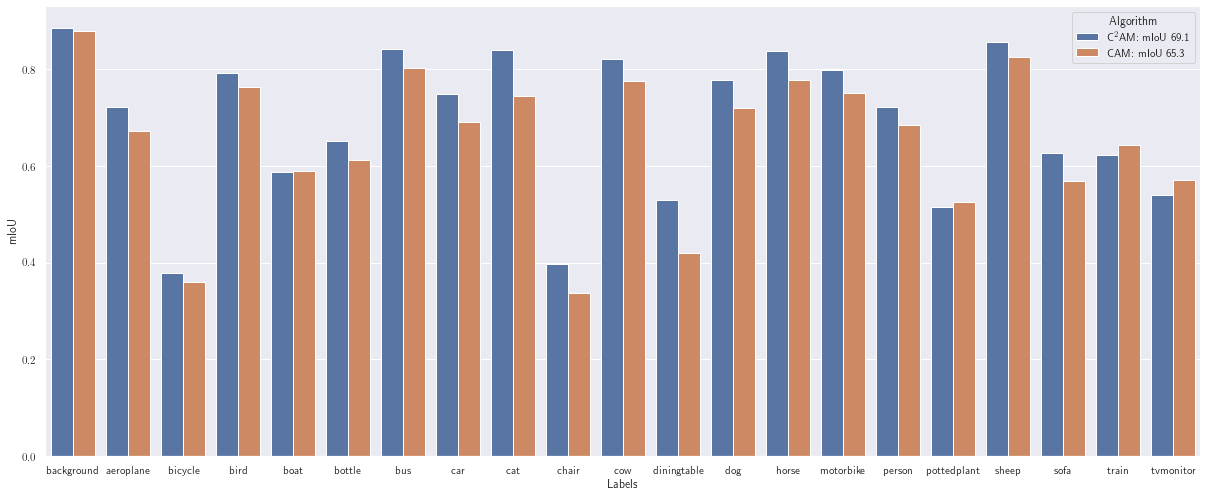

In [28]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.barplot(x="Labels", y="mIoU", hue="Algorithm", data=dfm)